# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

In [1]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"


In [3]:
# !pip list
# !pip install -q seaborn

In [1]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import random

np.set_printoptions(precision=3, suppress=True)

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 
Temperature is in celcius
Voltage is in volts
Current is in Amps

In [2]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [3]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [4]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [5]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [6]:
df['ambient_temperature'].nunique()

1

# Machine Learning (RBFN)

Now we begin to build our Radial Bias Function Network

https://www.kaggle.com/code/residentmario/radial-basis-networks-and-custom-keras-layers

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, RepeatVector, TimeDistributed, Layer
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from keras import backend as K
from keras.losses import binary_crossentropy
import warnings

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)
train_dataset = prep_df.sample(frac=0.8, random_state = 0)
test_dataset = prep_df.drop(train_dataset.index)

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,470279.0,95.409219,42.773598,1.000000,60.000000,96.000000,132.000000,168.000000
voltage_measured,470279.0,4.103417,0.213988,2.471315,4.087904,4.205138,4.205908,8.393141
current_measured,470279.0,0.368345,0.909263,-4.479660,0.039531,0.171773,1.262020,1.530376
temperature_measured,470279.0,26.375203,2.778615,23.214802,24.489668,25.483638,27.353169,41.450232
current,470279.0,0.635250,0.737908,-4.468000,0.057000,0.261000,1.498000,1.998400
voltage,470279.0,4.021478,1.213135,0.000000,4.240000,4.305000,4.656000,5.002000
time,470279.0,4763.490005,3149.187573,0.000000,1925.390000,4464.735000,7504.617000,10807.328000
capacity,470279.0,1.531792,0.171983,1.287453,1.370513,1.511898,1.694580,1.856487


In [12]:
# These are the features
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features.iloc[0])
# These contain the target variables
train_labels = train_features.pop('capacity')
test_labels = test_features.pop('capacity')
print('--------------------------')
print(train_features.iloc[0])

cycle                   144.000000
voltage_measured          4.072683
current_measured          1.510459
temperature_measured     26.956490
current                   1.500000
voltage                   4.818000
time                    952.812000
capacity                  1.334007
Name: 489563, dtype: float64
--------------------------
cycle                   144.000000
voltage_measured          4.072683
current_measured          1.510459
temperature_measured     26.956490
current                   1.500000
voltage                   4.818000
time                    952.812000
Name: 489563, dtype: float64


## Normalisation

Here we will normalise the values to give equal weight to each feature

In [18]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cycle,95.409219,42.773598
voltage_measured,4.103417,0.213988
current_measured,0.368345,0.909263
temperature_measured,26.375203,2.778615
current,0.635250,0.737908
voltage,4.021478,1.213135
time,4763.490005,3149.187573
capacity,1.531792,0.171983


In [19]:
train_dataset.head()

,cycle,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
489563,144,4.072683,1.510459,26.956490,1.500,4.818,952.812,1.334007
383688,118,4.201760,-0.000018,24.420418,0.000,0.003,10276.969,1.412579
580550,167,4.205604,0.081628,24.197675,0.080,4.261,6816.406,1.309015
110450,51,4.207076,0.030770,25.934192,0.031,4.240,9215.422,1.757018
354820,111,4.207394,1.136588,30.364207,1.130,4.775,2383.969,1.438671


## Regression with RBFN

### Reshaping the Data

In [14]:
print(train_features.shape)
print(train_features.iloc[0].shape)
print(train_features.iloc[0].squeeze)

(470279, 7)
(7,)
<bound method NDFrame.squeeze of cycle                   144.000000
voltage_measured          4.072683
current_measured          1.510459
temperature_measured     26.956490
current                   1.500000
voltage                   4.818000
time                    952.812000
Name: 489563, dtype: float64>


In [15]:
sample_size = train_features.shape[0] # number of samples in train set
time_steps  = train_features.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_features_reshaped = train_features.values.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_features_reshaped.shape)
print("1 Sample shape:\n",train_features_reshaped[0].shape)
print("An example sample:\n", train_features_reshaped[0])

After reshape train data set shape:
 (470279, 7, 1)
1 Sample shape:
 (7, 1)
An example sample:
 [[144.   ]
 [  4.073]
 [  1.51 ]
 [ 26.956]
 [  1.5  ]
 [  4.818]
 [952.812]]


In [17]:
test_features_reshaped = test_features.values.reshape(test_features.shape[0],test_features.shape[1],1)
n_timesteps = train_features_reshaped.shape[1] #7
n_features  = train_features_reshaped.shape[2] #1

In [18]:
normalizer = keras.layers.Normalization(axis = 1)
normalizer.adapt(np.array(train_features_reshaped))

In [19]:
train_features_reshaped = normalizer(train_features_reshaped)
test_features_reshaped= normalizer(test_features_reshaped)

In [20]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
    def get_config(self):
        config = super(RBFLayer, self).get_config()
        config.update({
            'units': self.units,
            'gamma': self.gamma,
        })
        return config

In [26]:
def build_and_compile_model(): 
    
    model = Sequential()
    model.add(Flatten(input_shape=(n_timesteps,n_features)))
    model.add(RBFLayer(200, 0.5))
    model.add(Dense(1, activation='relu', name='foo'))
    model.compile(loss= 'mean_squared_error',
                 optimizer = 'rmsprop', 
                 metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SOC]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [27]:
rbfn_model = build_and_compile_model()
rbfn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 rbf_layer_1 (RBFLayer)      (None, 200)               1400      
                                                                 
 foo (Dense)                 (None, 1)                 201       
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
epochs = 40
checkpoint_filepath = os.path.join('checkpoints', 'RBFN{epoch:02d}-{val_loss:.4f}.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

In [40]:
%%time
history.append(rbfn_model.fit(
    train_features_reshaped,
    train_labels,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

Epoch 1/40
11757/11757 [==============================] - 69s 6ms/step - loss: 6.0366e-04 - mean_squared_error: 6.0366e-04 - mean_absolute_error: 0.0158 - val_loss: 5.0458e-04 - val_mean_squared_error: 5.0458e-04 - val_mean_absolute_error: 0.0140
Epoch 2/40
11757/11757 [==============================] - 67s 6ms/step - loss: 5.1770e-04 - mean_squared_error: 5.1770e-04 - mean_absolute_error: 0.0144 - val_loss: 7.0826e-04 - val_mean_squared_error: 7.0826e-04 - val_mean_absolute_error: 0.0186
Epoch 3/40
11757/11757 [==============================] - 67s 6ms/step - loss: 4.4497e-04 - mean_squared_error: 4.4497e-04 - mean_absolute_error: 0.0134 - val_loss: 3.7057e-04 - val_mean_squared_error: 3.7057e-04 - val_mean_absolute_error: 0.0118
Epoch 4/40
11757/11757 [==============================] - 68s 6ms/step - loss: 3.8099e-04 - mean_squared_error: 3.8099e-04 - mean_absolute_error: 0.0126 - val_loss: 3.0668e-04 - val_mean_squared_error: 3.0668e-04 - val_mean_absolute_error: 0.0111
Epoch 5/40
1

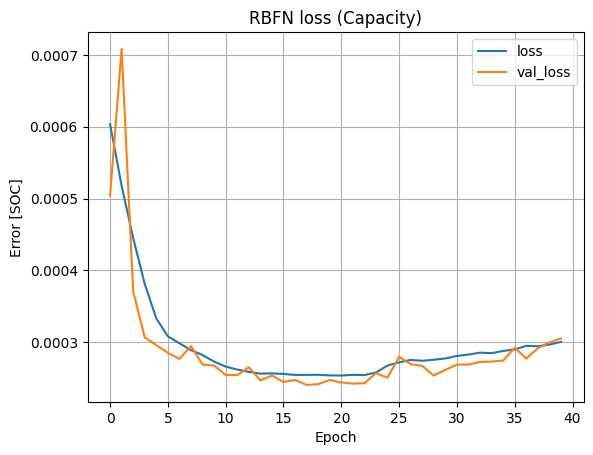

In [41]:
plot_loss(history[-1], 'RBFN loss (Capacity)')

In [42]:
model_path = os.path.join("models","RBFN_02.keras")

In [50]:
checkpoint_path = os.path.join('checkpoints', 'RBFN17-0.0002.h5')

In [51]:
rbfn_model = build_and_compile_model()
rbfn_model.load_weights(checkpoint_path)

In [52]:
rbfn_model.save(model_path)

### Performance

In [44]:
rbfn_model = tf.keras.models.load_model(model_path, custom_objects={'RBFLayer': RBFLayer})

In [53]:
test_predictions = rbfn_model.predict(test_features_reshaped).flatten()

3675/3675 [==============================] - 5s 1ms/step


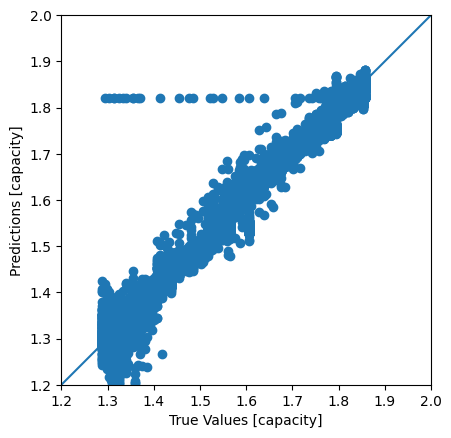

In [54]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [capacity]')
plt.ylabel('Predictions [capacity]')
lims = [1.2, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

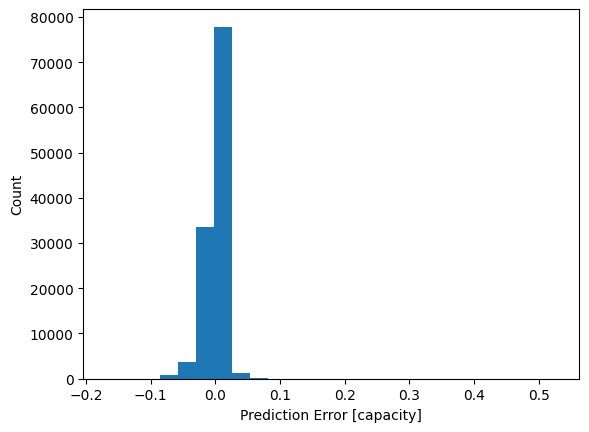

In [55]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')

In [56]:
# Calculate metrics
mse = mean_squared_error(test_labels, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 0.00025510543728627944
RMSE: 0.015972020450972364
MAE: 0.010595383553837065
R2 Score: 0.9913735334202339
